In [1]:
# ===================================================================
# 由於課堂上可能有多⼈共⽤同⼀顆GPU，以下限定使⽤者只能⽤計算卡上45%的記憶體。
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45 # 使⽤45%記憶體
set_session(tf.Session(config=config))
# ===================================================================

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
import xgboost

In [3]:
if 'df_realestate.csv' not in os.listdir('data'):
    url = 'https://s3.amazonaws.com/datasets-jeremy/df_realestate.csv'  
    urllib.request.urlretrieve(url, os.path.join('data', 'df_realestate.csv')) 
    
if 'df_realestate_processed.csv' not in os.listdir('data'):
    url = 'https://s3.amazonaws.com/datasets-jeremy/df_realestate_processed.csv'  
    urllib.request.urlretrieve(url, os.path.join('data', 'df_realestate_processed.csv'))  

In [4]:
# before preprocessing
file = os.path.join('data', 'df_realestate.csv')
df_realestate = pd.read_csv(file, encoding='big5')
df_realestate

# processed
path = "data//df_realestate_processed.csv"
df_realestate_processed = pd.read_csv(path)
X = df_realestate_processed.drop(["price_per_meter", "total_price"], axis=1)
Y = df_realestate_processed['total_price']


/opt/intel/intelpython3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,8,11,13,21,29,32,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Start Your Code Here

In [5]:
print(df_realestate_processed)

       price_per_meter     area  house_year  have_manager  current_division  \
0             107118.0   101.57   16.000000             1                 1   
1             113824.0   254.79   27.000000             1                 1   
2             176534.0    56.08   21.000000             1                 1   
3              90076.0    92.70   35.000000             1                 1   
4             112097.0    42.82   22.000000             1                 1   
5             154628.0   119.71    4.000000             1                 1   
6             242063.0    57.01   41.000000             0                 1   
7             138669.0    25.24   39.000000             1                 1   
8             194452.0   103.47   18.000000             0                 1   
9             285526.0   136.59   11.000000             1                 1   
10            154284.0   105.52    7.000000             1                 1   
11            195141.0   129.66    7.000000         

In [10]:
df_info = df_realestate_processed.info()
print(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52950 entries, 0 to 52949
Columns: 254 entries, price_per_meter to cross_business_factory
dtypes: float64(100), int64(154)
memory usage: 102.6 MB
None


In [11]:
df_des = df_realestate_processed.describe()
print(df_des)

       price_per_meter          area    house_year  have_manager  \
count     5.295000e+04  52950.000000  52948.000000  52950.000000   
mean      1.956014e+05    152.121258     21.946415      0.646062   
std       2.879133e+05    531.810018     14.603055      0.478195   
min       2.011700e+04      1.100000      0.000000      0.000000   
25%       1.408512e+05     70.430000      8.000000      0.000000   
50%       1.790410e+05    106.585000     22.000000      1.000000   
75%       2.267478e+05    165.927500     35.000000      1.000000   
max       6.268571e+07  69125.530000    103.000000      1.000000   

       current_division  have_added_building  is_for_household  \
count      52950.000000         52950.000000       52950.00000   
mean           0.898829             0.274788           0.73779   
std            0.301558             0.446411           0.43984   
min            0.000000             0.000000           0.00000   
25%            1.000000             0.000000           0.

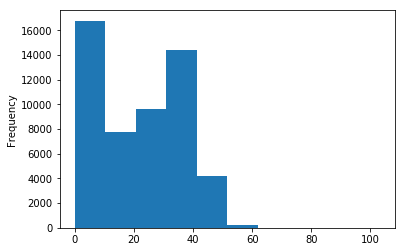

In [8]:
hy_ax = df_realestate_processed['house_year'].plot('hist')
#plt.show()

In [27]:
from sklearn.model_selection  import train_test_split
X_train = X.iloc[:-1000]
Y_train = Y.iloc[:-1000]
Y_train = np.log(Y_train)

X_valid = X.iloc[-1000:]
Y_valid = Y.iloc[-1000:]
Y_valid = np.log(Y_valid)

X_train, _z, Y_train, _zz = train_test_split(X_train, Y_train, test_size =0.75, random_state=123) 

In [28]:
print(X.shape)
print(X_train.shape)
print(X_valid.shape)

print(Y_train.shape)
print(Y_valid.shape)


(52950, 252)
(12987, 252)
(1000, 252)
(12987,)
(1000,)


In [37]:
# Set our parameters for xgboost
params = {}

# 請填入以下參數: 
# 目標函數: 線性回歸
# 評價函數: rmse
# 學習速度: 0.01
# 最大深度: 5
# bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
#=============your works starts===============#
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.03
params['max_depth'] = 3
d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
#==============your works ends================#

[0]	train-rmse:15.8171	valid-rmse:15.6216
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:11.6691	valid-rmse:11.5302
[20]	train-rmse:8.61053	valid-rmse:8.51674
[30]	train-rmse:6.35542	valid-rmse:6.29824
[40]	train-rmse:4.69318	valid-rmse:4.66524
[50]	train-rmse:3.46854	valid-rmse:3.46294
[60]	train-rmse:2.56715	valid-rmse:2.58298
[70]	train-rmse:1.90476	valid-rmse:1.9354
[80]	train-rmse:1.41927	valid-rmse:1.46437
[90]	train-rmse:1.06505	valid-rmse:1.12147
[100]	train-rmse:0.808592	valid-rmse:0.874877
[110]	train-rmse:0.625243	valid-rmse:0.69983
[120]	train-rmse:0.496629	valid-rmse:0.580618
[130]	train-rmse:0.408786	valid-rmse:0.498844
[140]	train-rmse:0.350687	valid-rmse:0.444923
[150]	train-rmse:0.31347	valid-rmse:0.410181
[160]	train-rmse:0.290237	valid-rmse:0.389054
[170]	train-rmse:0.275742	valid-rmse:0.375385
[180]	train-rmse:0.26656	valid-rmse:0.365319
[190]	train-rmse

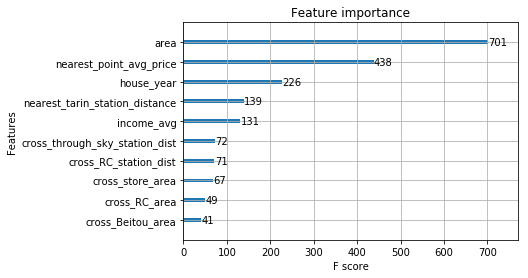

In [38]:
# 請使用 xgboost.plot_importance，並設定max_num_features=10
#!=============your works starts===============!#
xgboost.plot_importance(bst, max_num_features=10)
#!==============your works ends================!#

plt.show()

In [40]:
df_result = pd.DataFrame()

# 1. 使用X_valid去評價此模型
# 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
#    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
#    (2). error 請使用計算(predict-truth)/truth計算誤差百分比
#=============your works starts===============#
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
df_result['predict'] = np.exp(Y_pred)
df_result['truth'] = np.exp((list(Y_valid)))
df_result['error'] = df_result.apply(lambda x:np.abs(x['predict'] - x['truth']) / x['truth'], axis=1)
df_result_sort = df_result.sort_values('truth')
#==============your works ends================#

df_result.head()

,predict,truth,error
0,16558211.0,15880006.78,0.042708
1,12144483.0,10999982.00,0.104046
2,30092590.0,28199982.04,0.067114
3,23153862.0,21920043.69,0.056287
4,5145388.0,3220663.36,0.597617


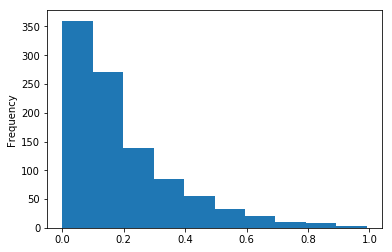

In [41]:
# 請使用df_result_sort濾掉error大於1的部分畫出error的分布圖
#!=============your works starts===============!#
df_result_sort.loc[df_result_sort['error'] < 1, 'error'].plot('hist')
#!==============your works ends================!#

plt.show()

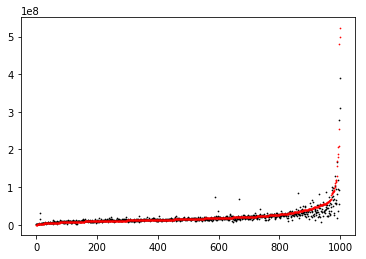

In [42]:
# 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
#!=============your works starts===============!#
plt.scatter(range(len(df_result)), df_result_sort['predict'].values, color='black', s=0.5)
plt.scatter(range(len(df_result)), df_result_sort['truth'].values, color='red', s=0.5)
#!==============your works ends================!#

plt.show()